In [1]:
import mat4py
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import scipy.io
import os 
from sklearn.model_selection import KFold
import math
import scipy.io
import matplotlib.pyplot as plt
from random import sample


## 
## load data

CellNames = scipy.io.loadmat('../Cells2Connectomes/CellType_Names.mat')
CellNames = CellNames['cellnames'] 

Connectomes = scipy.io.loadmat('../Cells2Connectomes/Connectomes.mat')
Connectome_direct = Connectomes['C_dir']


'''

Region volumes, in a 424 vector, to get connectivity density, divide
% each row in connectomes by each entry in the vector to get density. Units
% are in 200 micron per vertex voxels.

'''

CellType_volumn = mat4py.loadmat('../Cells2Connectomes/Regional_Volumes.mat')
CellType_volumn = CellType_volumn['region_vols']
Celltype_volumn =np.array([np.array(xi) for xi in CellType_volumn])
print(Celltype_volumn.shape)

# Nomarlize by the entry

Connectome_direct_density = Connectome_direct/Celltype_volumn

CellNames = [CellNames[0][x][0] for x in list(range(25))]

labels = ['P:'+ x for x in CellNames] + ['R:'+ x for x in CellNames]



# Import Tasic data, using the 25 cell type features

Cell_type = mat4py.loadmat('../Cells2Connectomes/Tasic_nG_606_TypeDensity.mat')
Cell_type = Cell_type['cell_type_density_nG606']
Celltype_mtx =np.array([np.array(xi) for xi in Cell_type])

# Important : normalizing via the columns

Celltype_mtx_norm =(Celltype_mtx-Celltype_mtx.min(axis=0)) / (Celltype_mtx.max(axis=0) - Celltype_mtx.min(axis=0) )



(424, 1)


In [4]:
# random forest

# build a df to store the information

# instead use the subset, this time I am trying the whole, which might be not suitable for ML, but I just wanted a positive control
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res_df =[]


Target = []
Dataset = []


for i in range(Celltype_mtx_norm.shape[0]):
    for j in range(Celltype_mtx_norm.shape[0]):
        # ignore self connectivity

        if i == j:
            Connectome_direct_density[i,j] = 0
            pass       
        else:

            #_Dataset_Training = np.concatenate((Dataset_Train_set[i,:],Dataset_Train_set[j,:]))
            #Dataset_Training = np.stack((Dataset_Training,_Dataset_Training))
            Dataset.append(np.concatenate((Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])))
            Target.append(Connectome_direct_density[i,j])
            
            

Dataset = np.stack(Dataset)

capped_Target = [math.log2(x+1) for x in Target]
Target =np.array([np.array(xi) for xi in capped_Target])   

Dataset= Dataset[list(np.where(Target != 0)[0])]
Target = Target[list(np.where(Target != 0)[0])]

In [21]:
def flatten_list(_2d_list):
    flat_list = []
    for element in _2d_list:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list


Region_maps = mat4py.loadmat('../Cells2Connectomes/Region_Names.mat')
Region_maps = Region_maps['region_names']
Region_maps = mat4py.loadmat('../Cells2Connectomes/Region_Names.mat')
Region_maps = Region_maps['region_names']

Regionmaps_df = pd.DataFrame(Region_maps,columns = ['Anno1','Anno2','Anno3'])

Region_maps_list = flatten_list(Region_maps)
Region_maps_list

Region_maps_array = np.array(Region_maps_list)
Region_maps_array_2d = np.reshape(Region_maps_array, (3,212))
Regionmaps_df['Anno1'] = Region_maps_array_2d[0]
Regionmaps_df['Anno2'] = Region_maps_array_2d[1]
Regionmaps_df['Anno3'] = Region_maps_array_2d[2]

#  adj region and not adj region

Adj_mtx = mat4py.loadmat('../Cells2Connectomes/region_neighbors_mouse.mat')
Adj_mtx = Adj_mtx['neighbors_mat_bin']
Adj_mtx =np.array([np.array(xi) for xi in Adj_mtx])
Adj_mtx.shape

refine_index = list(Regionmaps_df[Regionmaps_df['Anno2'].isin(['Medulla','Midbrain','Pons','Cerebellar Cortex','Cerebellar Nuclei'])].index)

refine_index = refine_index + [(x + 212) for x in refine_index]

for i in range(424):
    for j in range(424):
        if (i <212) != (j<212):
            if (i not in refine_index) and (j not in refine_index):
                Adj_mtx[i][j] = 0

In [3]:
# data vis
import mat4py
Adj_mtx_1 = mat4py.loadmat('../Cells2Connectomes/region_neighbors_mouse.mat')
Adj_mtx_1 = Adj_mtx_1['neighbors_mat_bin']


Adj_mtx_2 = mat4py.loadmat('../Cells2Connectomes/region_neighbors.mat')
Adj_mtx_2 = Adj_mtx_2['neighbors_mat']

<AxesSubplot:>

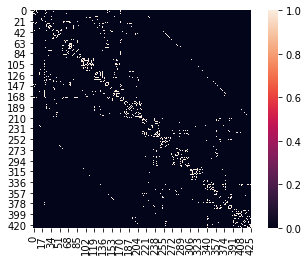

In [5]:
import seaborn as sns

sns.heatmap(Adj_mtx_1, square = True)

<AxesSubplot:>

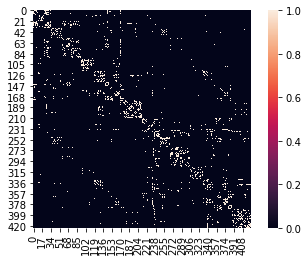

In [6]:
sns.heatmap(Adj_mtx_2, square = True)

# Adj

In [44]:
# random forest

# build a df to store the information


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res_df =[]


Target = []
Dataset = []



for i in range(Celltype_mtx_norm.shape[0]):
    for j in range(Celltype_mtx_norm.shape[0]):
        
        if i >= 212 :
            i_ = i - 212
        else:
            i_ = i
        
        if j >= 212 :
            j_ = j - 212
        else:
            j_ = j
        if (Regionmaps_df['Anno2'][i_] == Regionmaps_df['Anno2'][j_] ):
            if ((i >= 212) == (j >= 212)):
                
                close_region = 1
            else: 
                close_region = 1
        else:
            close_region = 0
        
        #print(i)
        #print(j)
        if i == j:
            pass       
        else:
            if Adj_mtx[i][j] == 1:
                
                #_Dataset_Training = np.concatenate((Dataset_Train_set[i,:],Dataset_Train_set[j,:]))
                #Dataset_Training = np.stack((Dataset_Training,_Dataset_Training))
                Dataset.append(np.concatenate((Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])))
                                          
                Target.append(Connectome_direct_density[i,j])
            else:
                pass
            
            
print('?')
Dataset = np.stack(Dataset)
#capped_Target = [5 if x>5 else x for x in Target]
capped_Target = [math.log2(x+1) for x in Target]
Target =np.array([np.array(xi) for xi in capped_Target])   

Dataset= Dataset[list(np.where(Target != 0)[0])]
Target = Target[list(np.where(Target != 0)[0])]
print(Dataset.shape)
print(Target.shape) 

?
(1665, 50)
(1665,)


In [46]:
   
#X_train, X_test, y_train, y_test = train_test_split(Dataset, Target,test_size=.2,random_state =123)  

# in total 55 features, (25 + 25) + 1 + (1 + 1) + (1 + 1)
kf = KFold(n_splits=10, shuffle= True)
list_r2 = []

p = 0 
for train_index, test_index in kf.split(Dataset):
    p = p + 1
    #print(train_index)
    #print(test_index)
    sub1 = train_index#), int(len(train_index))
    sub2 = test_index#), int(len(test_index)/50))
    X_train, X_test = Dataset[sub1], Dataset[sub2]
    y_train, y_test = Target[sub1], Target[sub2]
    RF_model_1 = RandomForestRegressor(n_estimators=100,max_features = 20,max_depth=30)
    RF_model_1.fit(X_train, y_train)
    print('Traing fit')
    Predict = RF_model_1.predict(X_train)
    print(r2_score(y_train, Predict))
    print('Testing fit')
    Predict = RF_model_1.predict(X_test)
    print(r2_score(y_test, Predict))
    list_r2.append(r2_score(y_test, Predict))
    importances = RF_model_1.feature_importances_
    indices = np.argsort(importances)[::-1]
    Celltype_scores = importances[:25] + importances[25:]
    if p ==1 :
        
        df_feature_important_adj = {'Celltype_Names': CellNames, 'Feature_importance': list(Celltype_scores)}
        df_feature_important_adj = pd.DataFrame(data=df_feature_important_adj,dtype=np.int32)
    else:
        _df_feature_important_adj = {'Celltype_Names': CellNames, 'Feature_importance': list(Celltype_scores)}
        _df_feature_important_adj = pd.DataFrame(data=_df_feature_important_adj,dtype=np.int32)
        df_feature_important_adj = df_feature_important_adj.append(_df_feature_important_adj)
        
adj_cell = list_r2.copy()

Traing fit
0.9085287349730156
Testing fit
0.4295365393145163
Traing fit
0.9112691044617625
Testing fit
0.4661660021614492
Traing fit
0.9071427553470842
Testing fit
0.4153919676064033
Traing fit
0.9140653943017588
Testing fit
0.3604389800455584
Traing fit
0.9116132123395057
Testing fit
0.3581062780009394
Traing fit
0.9123038966184281
Testing fit
0.34242184489272776
Traing fit
0.9133138634376521
Testing fit
0.2646269832074699
Traing fit
0.9131066089711697
Testing fit
0.3447013470835838
Traing fit
0.9150556248423385
Testing fit
0.4213962287374381
Traing fit
0.914246754246511
Testing fit
0.3109380836318931


<ipython-input-47-6c70d96dc519>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


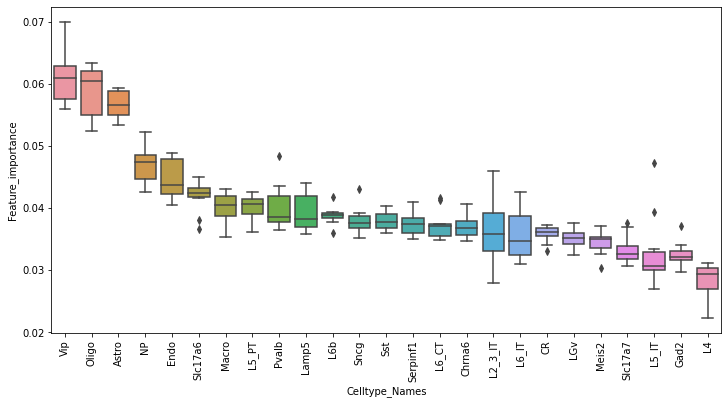

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt


#import mylib

a4_dims = (12,6)
fig, ax = plt.subplots(figsize=a4_dims)

df_feature_important_adj.index = list(range(250))
grouped = df_feature_important_adj.groupby('Celltype_Names')

users_sorted_average = (
    pd.DataFrame({col: vals['Feature_importance'] for col, vals in grouped})
    .mean()
    .sort_values(ascending=False)
)
grid = sns.boxplot( ax=ax,x=df_feature_important_adj["Celltype_Names"], y=df_feature_important_adj['Feature_importance'], 
                   order=users_sorted_average.index)
# Rotate the labels on x-axis
grid.set_xticklabels(labels=users_sorted_average.index, rotation=90)

fig.show()

#fig.savefig('Figure/Boxplot_celltype_featureimportance_only_Adjregions.pdf')

# non-Adj

In [56]:
# random forest

# build a df to store the information


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
res_df =[]


Target = []
Dataset = []



for i in range(Celltype_mtx_norm.shape[0]):
    for j in range(Celltype_mtx_norm.shape[0]):
        
        if i >= 212 :
            i_ = i - 212
        else:
            i_ = i
        
        if j >= 212 :
            j_ = j - 212
        else:
            j_ = j
        if (Regionmaps_df['Anno2'][i_] == Regionmaps_df['Anno2'][j_] ):
            if ((i >= 212) == (j >= 212)):
                
                close_region = 1
            else: 
                close_region = 1
        else:
            close_region = 0
        
        #print(i)
        #print(j)
        if i == j:
            pass       
        else:
            if Adj_mtx[i][j] == 0:
                
                #_Dataset_Training = np.concatenate((Dataset_Train_set[i,:],Dataset_Train_set[j,:]))
                #Dataset_Training = np.stack((Dataset_Training,_Dataset_Training))
                Dataset.append(np.concatenate((Celltype_mtx_norm[i,:],Celltype_mtx_norm[j,:])))
                                          
                Target.append(Connectome_direct_density[i,j])
            else:
                pass
            
            
print('?')
Dataset = np.stack(Dataset)
#capped_Target = [5 if x>5 else x for x in Target]
capped_Target = [math.log2(x+1) for x in Target]
Target =np.array([np.array(xi) for xi in capped_Target])   

Dataset= Dataset[list(np.where(Target != 0)[0])]
Target = Target[list(np.where(Target != 0)[0])]
print(Dataset.shape)
print(Target.shape) 

?
(62711, 50)
(62711,)


In [57]:
   
#X_train, X_test, y_train, y_test = train_test_split(Dataset, Target,test_size=.2,random_state =123)  

# in total 55 features, (25 + 25) + 1 + (1 + 1) + (1 + 1)
kf = KFold(n_splits=10, shuffle= True)
list_r2 = []

p = 0 
for train_index, test_index in kf.split(Dataset):
    p = p + 1
    #print(train_index)
    #print(test_index)
    sub1 = train_index#), int(len(train_index))
    sub2 = test_index#), int(len(test_index)/50))
    X_train, X_test = Dataset[sub1], Dataset[sub2]
    y_train, y_test = Target[sub1], Target[sub2]
  
    
    
    #reg = LazyRegressor(verbose=1, predictions=True,ignore_warnings=False, custom_metric=None)
    #models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    #print(models)
    
    #RF_model = RandomForestRegressor(n_estimators=100,max_features = 60,max_depth=20,min_samples_split =3)#,warm_start = True)  # height
    
    RF_model = RandomForestRegressor(n_estimators=100,max_features = 20,max_depth=30)
    RF_model.fit(X_train, y_train)
    print('Traing fit')
    Predict = RF_model.predict(X_train)
    print(r2_score(y_train, Predict))
    print('Testing fit')
    Predict = RF_model.predict(X_test)
    print(r2_score(y_test, Predict))
    list_r2.append(r2_score(y_test, Predict))
    importances = RF_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    Celltype_scores = importances[:25] + importances[25:]
    if p ==1 :
        
        df_feature_important = {'Celltype_Names': CellNames, 'Feature_importance': list(Celltype_scores)}
        df_feature_important = pd.DataFrame(data=df_feature_important,dtype=np.int32)
    else:
        _df_feature_important = {'Celltype_Names': CellNames, 'Feature_importance': list(Celltype_scores)}
        _df_feature_important = pd.DataFrame(data=_df_feature_important,dtype=np.int32)
        df_feature_important = df_feature_important.append(_df_feature_important)
        
non_adj_cell = list_r2.copy()

Traing fit
0.9400463986325325
Testing fit
0.5962007216621005
Traing fit
0.9408089001915662
Testing fit
0.5872351163963396
Traing fit
0.9406192364077599
Testing fit
0.5671755227644595
Traing fit
0.940784022971006
Testing fit
0.584433635047406
Traing fit
0.9414138856620614
Testing fit
0.5750248067457433
Traing fit
0.9407107730438983
Testing fit
0.594870978021171
Traing fit
0.9413054703007329
Testing fit
0.5770649706520968
Traing fit
0.9411631514805968
Testing fit
0.565915756833401
Traing fit
0.9404617711924271
Testing fit
0.5840468784302182
Traing fit
0.9401083313224385
Testing fit
0.6031242387432422


<ipython-input-43-19eceb867154>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


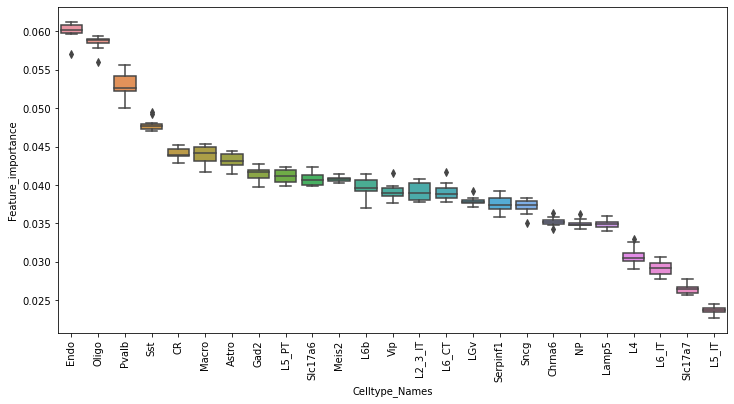

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt


#import mylib

a4_dims = (12,6)
fig, ax = plt.subplots(figsize=a4_dims)

df_feature_important.index = list(range(250))
grouped = df_feature_important.groupby('Celltype_Names')

users_sorted_average = (
    pd.DataFrame({col: vals['Feature_importance'] for col, vals in grouped})
    .mean()
    .sort_values(ascending=False)
)
grid = sns.boxplot( ax=ax,x=df_feature_important["Celltype_Names"], y=df_feature_important['Feature_importance'], 
                   order=users_sorted_average.index)
# Rotate the labels on x-axis
grid.set_xticklabels(labels=users_sorted_average.index, rotation=90)

fig.show()


<ipython-input-122-6977fccfaa10>:52: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


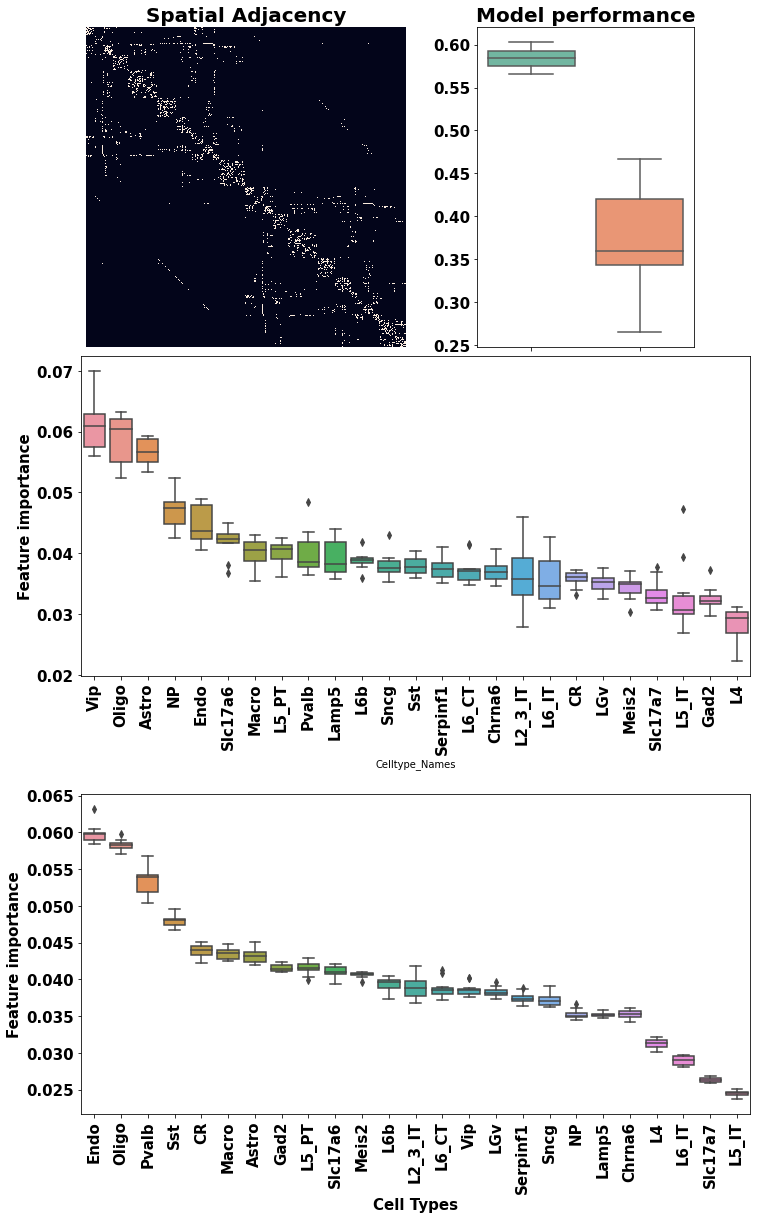

In [122]:
# assemble figures 
fig = plt.figure(figsize=(12, 22))

if 1 == 1:
    ax1 = plt.subplot2grid((22, 12), (0, 0), colspan=6, rowspan = 6)
    sns.heatmap(Adj_mtx, square = True, cbar =False, xticklabels=False, yticklabels=False, ax = ax1)
    ax1.set_title('Spatial Adjacency', fontsize = 20, weight = 'bold')
    
if 1==1:
    ax2 = plt.subplot2grid((22, 12), (0, 7), colspan=4, rowspan = 6)
    sns_plot = sns.boxplot(ax = ax2, data=[non_adj_cell, adj_cell],  palette="Set2")
    ax2.set_title('Model performance', fontsize = 20, weight = 'bold')
    changes = ['', '']
    ax2.set_xticklabels(changes)
    plt.yticks(fontsize=15, weight ='bold')
    
if 1==1:
    ax3 = plt.subplot2grid((22, 12), (6, 0), colspan=12, rowspan = 6)
    df_feature_important_adj.index = list(range(250))
    grouped = df_feature_important_adj.groupby('Celltype_Names')
    users_sorted_average = (
    pd.DataFrame({col: vals['Feature_importance'] for col, vals in grouped})
    .mean()
    .sort_values(ascending=False)
)
    grid = sns.boxplot( ax=ax3,x=df_feature_important_adj["Celltype_Names"], y=df_feature_important_adj['Feature_importance'], 
                       order=users_sorted_average.index)
    # Rotate the labels on x-axis
    grid.set_xticklabels(labels=users_sorted_average.index, rotation=90)
    plt.yticks(fontsize=15, weight ='bold')
    plt.xticks(fontsize=15, weight ='bold')
    
    ax3.set_ylabel('Feature importance',fontsize=15,  weight ='bold')
    #ax4.set_xlabel('Cell Types',fontsize=20,  weight ='bold')
if 1==1:
    ax4 = plt.subplot2grid((22, 12), (14, 0), colspan=12, rowspan = 6)
    df_feature_important.index = list(range(250))
    grouped = df_feature_important.groupby('Celltype_Names')
    users_sorted_average = (
    pd.DataFrame({col: vals['Feature_importance'] for col, vals in grouped})
    .mean()
    .sort_values(ascending=False)
)
    grid = sns.boxplot( ax=ax4,x=df_feature_important["Celltype_Names"], y=df_feature_important['Feature_importance'], 
                       order=users_sorted_average.index)
    # Rotate the labels on x-axis
    grid.set_xticklabels(labels=users_sorted_average.index, rotation=90)
    plt.yticks(fontsize=15, weight ='bold')
    plt.xticks(fontsize=15, weight ='bold')    
    ax4.set_xlabel('Cell Types',fontsize=15, weight ='bold')
    ax4.set_ylabel('Feature importance',fontsize=15,  weight ='bold')
fig.tight_layout()

fig.savefig('Figure/Fig5.pdf')

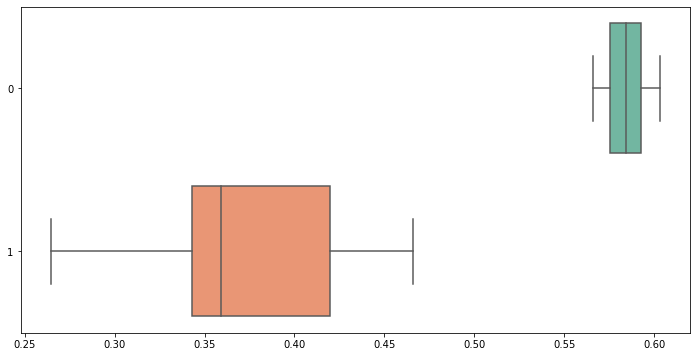

In [58]:
fig_size  = (20.27,6.7)
fig, ax = plt.subplots(figsize=a4_dims)
sns_plot = sns.boxplot(ax = ax, data=[non_adj_cell, adj_cell], orient="h", palette="Set2")
fig = sns_plot.get_figure()